# Import libraries

In [1]:
from datetime import datetime as dt

import re
import xarray as xr
import pathlib as pl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
%matplotlib notebook
%run ./utils.ipynb

# Parameters

In [206]:
# Temporal filters
YEAR_MONTH = "202011"
MIN_TIMESTAMP = "2020-11-01T00:00:00"
MAX_TIMESTAMP = "2020-11-30T18:00:00"

# Spatial filters
MIN_LATITUDE, MAX_LATITUDE = 0, 50
MIN_LONGITUDE, MAX_LONGITUDE = -50, -10

# Parameters
DATA_DIR = pl.Path.cwd().resolve().parent / "data"

In [220]:
# Processed parameters
ECMWF_SURFACE_DATA_FILEPATH = DATA_DIR / "ecmwf" / f"ecmwf-{YEAR_MONTH}-surface.grib"
ECMWF_500HPA_DATA_FILEPATH = DATA_DIR / "ecmwf" / f"ecmwf-{YEAR_MONTH}-500_1000Hpa.grib"
LAND_DATA_FILEPATH = DATA_DIR / "other" / "land_coast_mask.nc"

# Load and filter data

In [229]:
def load_and_filter_data():
    # Load ECMWF surface data
    ecmwf_data = xr.open_dataset(ECMWF_SURFACE_DATA_FILEPATH, engine='cfgrib')
    ecmwf_data = ecmwf_data.rename({
        "u10": "u_wind",
        "v10": "v_wind",
        "t2m": "temperature",
        "sp": "pressure",
        "tcc": "cloud_cover",
    }).sortby(["time", "latitude", "longitude"])
    ecmwf_data = ecmwf_data.sel(
        longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
        latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
        time=slice(MIN_TIMESTAMP, MAX_TIMESTAMP)
    )
    
    # Load ECMWF 500 Hpa data
    ecmwf_500_data = xr.open_dataset(ECMWF_500HPA_DATA_FILEPATH, engine='cfgrib')
    ecmwf_500_data = (
        ecmwf_500_data
        .rename({
            "u": "u_wind500",
            "v": "v_wind500",
            "t": "temperature500",
            "d": "divergence500",
            "w": "vertical_velocity"
        })
        .sortby(["time", "longitude", "latitude"])
        .sel(
            isobaricInhPa=slice(500, 500),
            longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
            latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
        )
        .mean(["isobaricInhPa"])
        [["u_wind500", "v_wind500", "temperature500", "divergence500", "vertical_velocity"]]
    )
    
    # Load land & coast data
    land_coast_data = xr.open_dataset(LAND_DATA_FILEPATH)
    land_coast_data = land_coast_data.sel(
        longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE),
        latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
    )
    # Merge
    data = xr.merge([ecmwf_data, ecmwf_500_data, land_coast_data]).sortby("time")
    return data

# Load ECMWF data
data = load_and_filter_data()
data = data.assign(wind_speed=lambda x: convert_ms_to_knot(np.sqrt(x.u_wind**2 + x.v_wind**2)))
data["pressure"] = data["pressure"] / 100

Ignoring index file '/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/data/ecmwf/ecmwf-202011-surface.grib.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 591, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1604188800, 1604210400, 1604232000, 1604253600, 1604275200,
       1604296800, 1604318400, 1604340000, 1604361600, 1604383200,
       1604404800, 1604426400, 1604448000, 1604469600, 1604491200,
       1604512800, 1604534400, 1604556000, 1604577600, 1604599200,
       1604

# Vortex center recognition


In [209]:
def identify_vortex_parameters(
    data: xr.Dataset,
    threshold: float,
) -> List[np.ndarray]:
    # Identify vortex centers
    centers = identify_vortexes_center(data, threshold=threshold, plot=False)
        
    # TODO: Identify vortex radius
    
    # TODO: Identify vortex orientation

    # Cast as Vortex
    vortexes = []
    for center in centers:
        center = Point(x=center[0].values, y=center[1].values)
        radius = EllipsisRadius(x=None, y=None)
        new_vortex = NormalizedVortex(center=center, radius=radius, orientation=1)
        vortexes.append(new_vortex)
    return vortexes

In [210]:
# Process recognition
time_to_vortex = {}
for timestamp in tqdm(data.time.values):
    # Filter wind data on timestamp
    tmp_data = data.sel(time=slice(timestamp, timestamp)).mean("time")
    # Identify vortexes
    vortexes = identify_vortex_parameters(tmp_data, threshold=5)
    time_to_vortex[pd.to_datetime(timestamp).strftime("%Y-%m-%d %Hh")] = vortexes

100%|██████████████████████████████████████████████████████████████████████████████████| 120/120 [00:11<00:00, 10.05it/s]


In [211]:
PLOT = False

if PLOT:
    def plot_vortexes(tmp_data, vortexes):
        # Get center data to plot
        lon_centers = [vortex.center.x for vortex in vortexes]
        lat_centers = [vortex.center.y for vortex in vortexes]

        # Plot vortexes
        quiver = plt.quiver(tmp_data["longitude"], tmp_data["latitude"], tmp_data["u_wind"], tmp_data["v_wind"])
        scatters = plt.scatter(lon_centers, lat_centers, color="red", s=100)
        plt.title(f"Vortex recognition - {tmp_data.time.values}")
        return quiver, scatters
    
    def get_tmp_data(i):
        return data.isel(time=i)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    initial_wind = data.isel(time=0)
    initial_time = pd.to_datetime(initial_wind.time.values).strftime("%Y-%m-%d %Hh")
    initial_vortexes = time_to_vortex.get(initial_time, [])
    quiver, scatters = plot_vortexes(initial_wind, initial_vortexes)

    def plot_vortexes_evolution(i_step):
        tmp_wind_data = get_tmp_data(i_step)
        tmp_wind_time = pd.to_datetime(tmp_wind_data.time.values).strftime("%Y-%m-%d %Hh")
        tmp_vortexes = time_to_vortex.get(tmp_wind_time, [])
        ax.clear()
        quiver, scatters = plot_vortexes(tmp_wind_data, tmp_vortexes)
        return quiver, scatters
    
    anim = animation.FuncAnimation(
        fig,
        plot_vortexes_evolution, 
        interval=1000,
        blit=False,
    )
    fig.tight_layout()
    plt.show()

In [217]:
max_distance_in_6h = 4
nb_successive_time_for_smoothing = 2
min_nb_of_data_point = 20

def get_new_index(vortex_to_idx):
    if len(vortex_to_idx) == 0:
        return 0
    vortex_indexes = [param["idx"] for param in vortex_to_idx.values()]
    return 1 + np.max(vortex_indexes)

# Match vortexes
h_step_to_explore = set(list(range(-nb_successive_time_for_smoothing, nb_successive_time_for_smoothing+1))) - {0}
vortex_to_idx = {}
for timestamp in data.time.values:
    timestamp = pd.to_datetime(timestamp)
    vortexes = time_to_vortex.get(timestamp.strftime("%Y-%m-%d %Hh"), [])
    for vortex in vortexes:
        vortex_idx = vortex_to_idx.get(vortex, {}).get("idx")
        for new_h in time_step_to_explore:
            new_timestamp = pd.to_datetime(timestamp) + pd.to_timedelta(new_h * 6, unit="H")
            new_vortexes = time_to_vortex.get(new_timestamp.strftime("%Y-%m-%d %Hh"), [])
            for new_vortex in new_vortexes:
                distance = np.sqrt((new_vortex.center.x - vortex.center.x)**2 + (new_vortex.center.y - vortex.center.y)**2)
                if distance * np.abs(new_h) <= max_distance_in_6h:
                    if vortex_idx is None:
                        new_idx = get_new_index(vortex_to_idx)
                        vortex_to_idx[vortex] = {"timestamp": timestamp, "idx": new_idx}
                        vortex_to_idx[new_vortex] = {"timestamp": new_timestamp, "idx": new_idx}
                    else:
                        vortex_to_idx[new_vortex] = {"timestamp": new_timestamp, "idx": vortex_idx}

# Revert dict order to get vortexes from index
idx_to_vortexes = {}
for vortex, param in vortex_to_idx.items():
    new_value = {"timestamp": param["timestamp"], "vortex": vortex}
    if param["idx"] in idx_to_vortexes:
        idx_to_vortexes[param["idx"]].append(new_value)
    else:
        idx_to_vortexes[param["idx"]] = [new_value]
        

# Include / exclude vortexes
time_to_included_vortex = {}
time_to_excluded_vortex = {}
for timestamp in data.time.values:
    timestamp = pd.to_datetime(timestamp).strftime("%Y-%m-%d %Hh")
    vortexes = time_to_vortex.get(timestamp, [])
    for vortex in vortexes:
        if vortex in vortex_to_idx and len(idx_to_vortexes[vortex_to_idx[vortex]["idx"]]) >= min_nb_of_data_point:
            if timestamp in time_to_included_vortex:
                time_to_included_vortex[timestamp].append(vortex)
            else:
                time_to_included_vortex[timestamp] = [vortex]
        else:
            if timestamp in time_to_excluded_vortex:
                time_to_excluded_vortex[timestamp].append(vortex)
            else:
                time_to_excluded_vortex[timestamp] = [vortex]


<IPython.core.display.Javascript object>


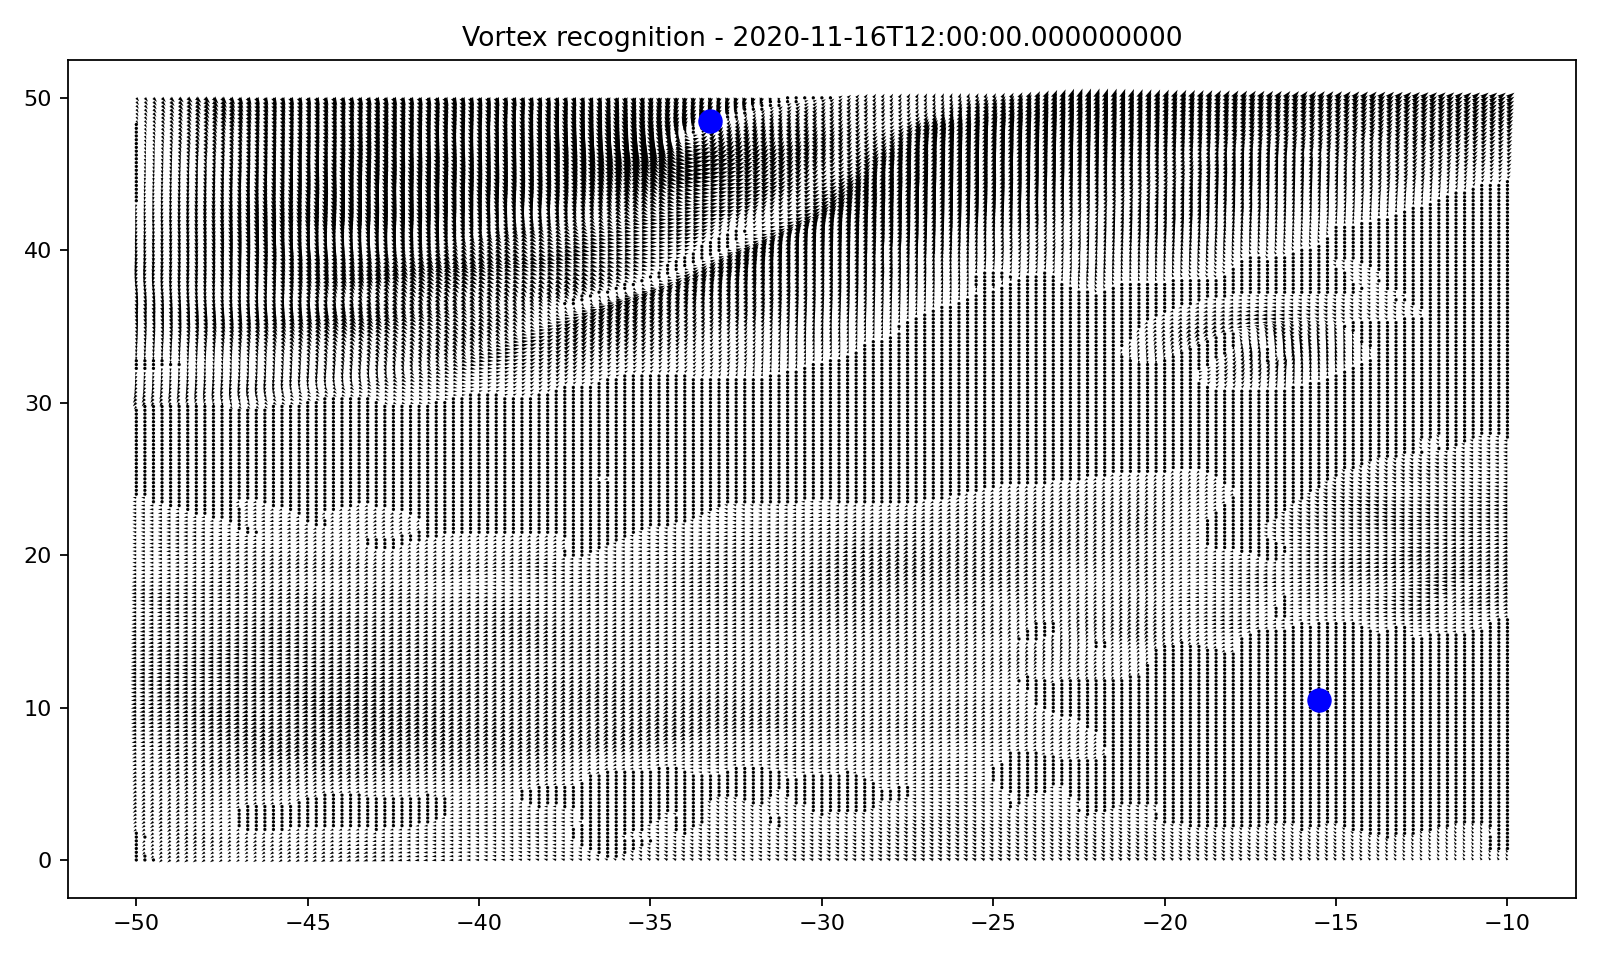

In [218]:
PLOT = True

if PLOT:
    def plot_vortexes(tmp_data, included_vortexes, excluded_vortexes):
        # Get center data to plot
        lon_included_centers = [vortex.center.x for vortex in included_vortexes]
        lat_included_centers = [vortex.center.y for vortex in included_vortexes]
        lon_excluded_centers = [vortex.center.x for vortex in excluded_vortexes]
        lat_excluded_centers = [vortex.center.y for vortex in excluded_vortexes]

        # Plot vortexes
        quiver = plt.quiver(tmp_data["longitude"], tmp_data["latitude"], tmp_data["u_wind"], tmp_data["v_wind"])
        scatters = plt.scatter(lon_included_centers, lat_included_centers, color="red", s=100)
        scatters = plt.scatter(lon_excluded_centers, lat_excluded_centers, color="blue", s=100)
        plt.title(f"Vortex recognition - {tmp_data.time.values}")
        return quiver, scatters
    
    def get_tmp_data(i):
        return data.isel(time=i)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    initial_wind = data.isel(time=0)
    initial_time = pd.to_datetime(initial_wind.time.values).strftime("%Y-%m-%d %Hh")
    initial_included_vortexes = time_to_included_vortex.get(initial_time, [])
    initial_excluded_vortexes = time_to_excluded_vortex.get(initial_time, [])
    quiver, scatters = plot_vortexes(initial_wind, initial_included_vortexes, initial_excluded_vortexes)

    def plot_vortexes_evolution(i_step):
        tmp_wind_data = get_tmp_data(i_step)
        tmp_wind_time = pd.to_datetime(tmp_wind_data.time.values).strftime("%Y-%m-%d %Hh")
        tmp_included_vortexes = time_to_included_vortex.get(tmp_wind_time, [])
        tmp_excluded_vortexes = time_to_excluded_vortex.get(tmp_wind_time, [])
        ax.clear()
        quiver, scatters = plot_vortexes(tmp_wind_data, tmp_included_vortexes, tmp_excluded_vortexes)
        return quiver, scatters
    
    anim = animation.FuncAnimation(
        fig,
        plot_vortexes_evolution, 
        interval=600,
        blit=False,
    )
    fig.tight_layout()
    plt.show()

In [219]:
for idx, vortex in idx_to_vortexes.items():
    if len(vortex) > 15:
        print(idx, len(vortex))

12 31


<IPython.core.display.Javascript object>


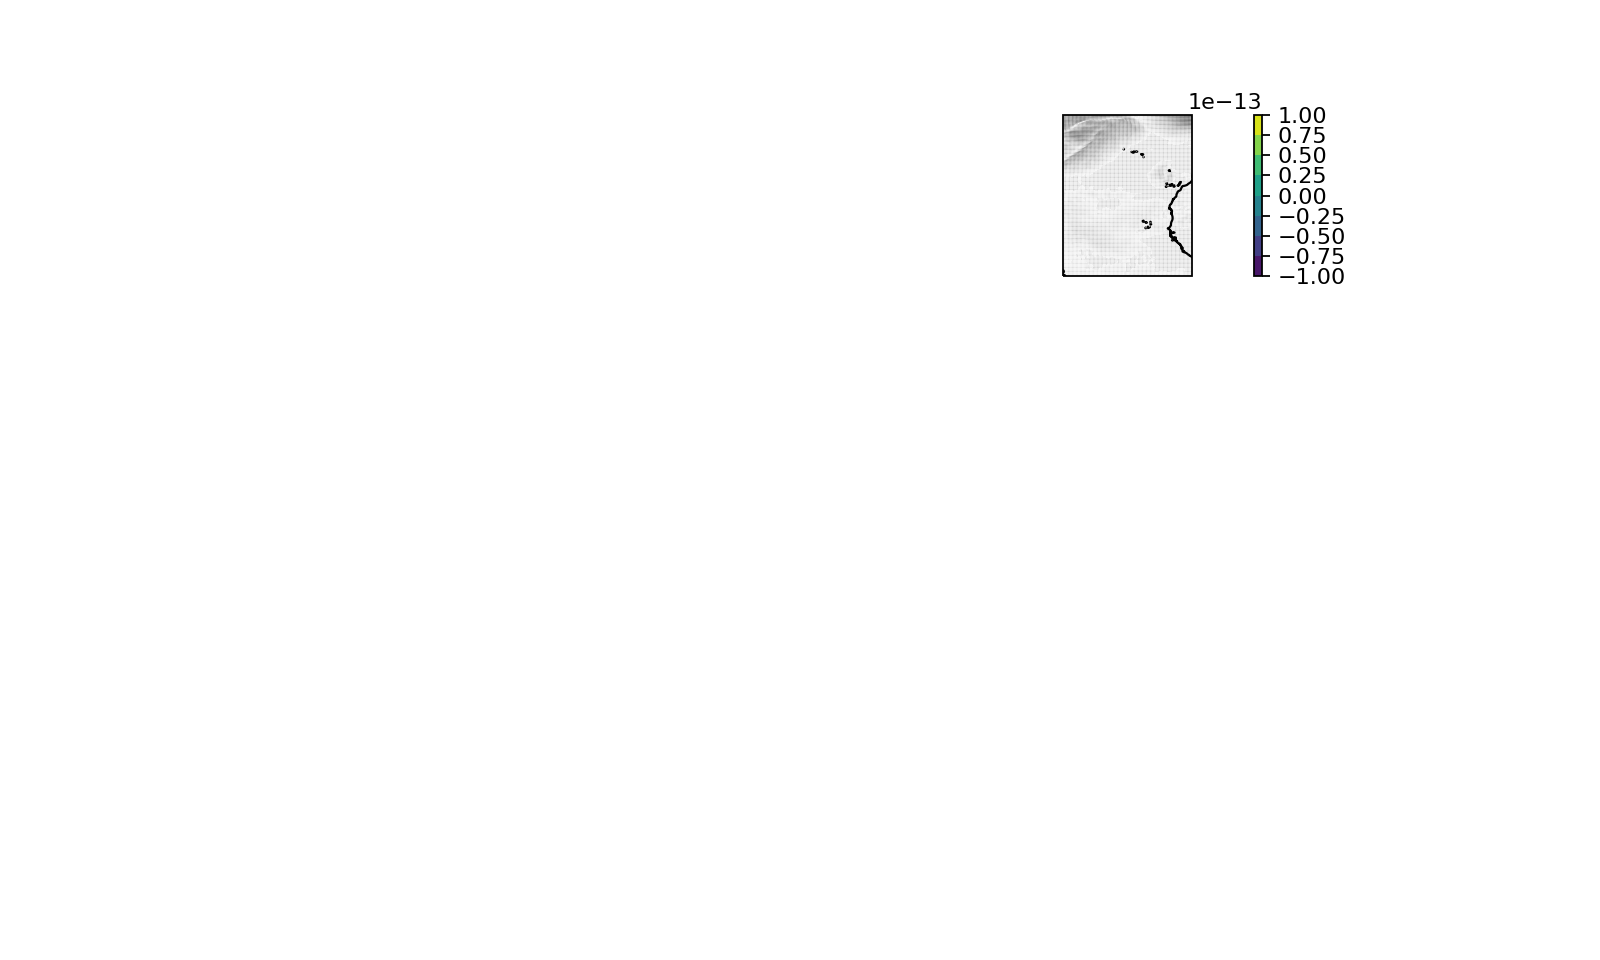

/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/dekergaradecerwan/Work/Trainings/Mindfuel_1221/.venv/lib/python3.8/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


In [236]:
DATE = "2020-11-15"
HOUR = "12"
TIMESTAMP = f"{DATE}T{HOUR}:00:00"
tmp_data = data.sel(time=slice(TIMESTAMP, TIMESTAMP)).mean("time")

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(4, 1, 1, projection=ccrs.PlateCarree())
plt.contourf(
    tmp_data["longitude"],
    tmp_data["latitude"],
    tmp_data["vertical_velocity"],
    transform=ccrs.PlateCarree()
)
# plt.pcolormesh(tmp_data["longitude"], tmp_data["latitude"], tmp_data["pressure"], shading='nearest', cmap=plt.cm.get_cmap('coolwarm'))
ax.quiver(tmp_data["longitude"], tmp_data["latitude"], tmp_data["u_wind"], tmp_data["v_wind"])
ax.coastlines()
plt.colorbar()
plt.show()


